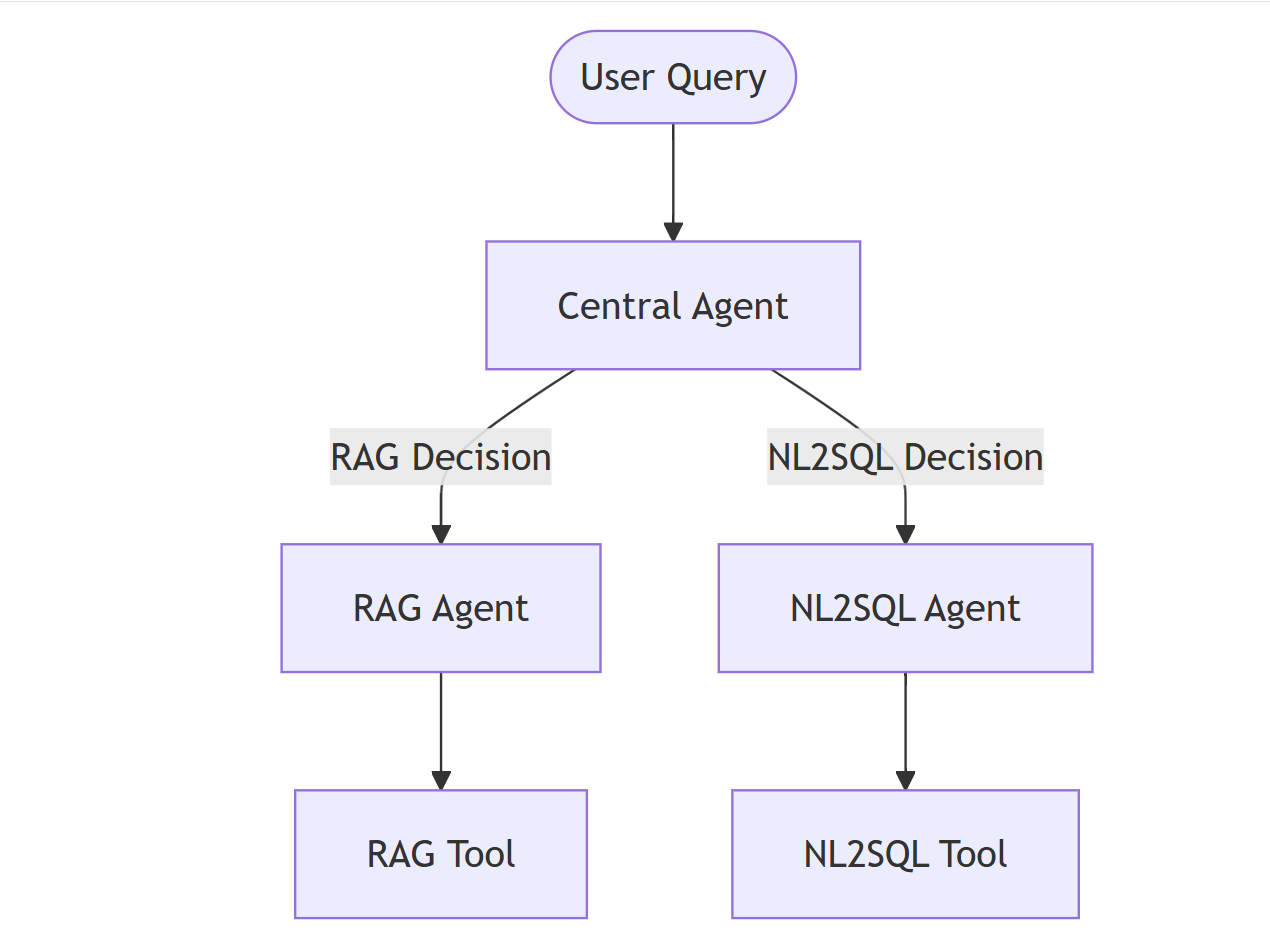

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image("/content/open ai swarm agent.png",width=800, height=500))

In [ ]:
!pip install -q git+https://github.com/openai/swarm.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
os.environ['OPENAI_API_KEY'] = 'YOUR OPENAI API KEY'

##Creating Agents and Handoffs

In [ ]:
from swarm import Swarm, Agent

def handoff_to_weather_agent():
    """Transfer the task to the weather agent."""
    print("Handing off to the weather agent.")
    return weather_agent

def handoff_to_math_agent():
    """Transfer the task to the math agent."""
    print("Handing off to the math agent.")
    return math_agent

weather_agent = Agent(
    name="Weather Agent",
    instructions="You handle weather-related queries. for other queries transfer to other agents",
    functions=[handoff_to_math_agent]
)


math_agent = Agent(
    name="Math Agent",
    instructions="You handle only mathematical queries.for other queries transfer to other agents",
    functions=[handoff_to_weather_agent]
)

In [ ]:
client = Swarm()

In [ ]:
messages = [{"role": "user", "content": "2+2"}]
response = client.run(agent=math_agent, messages=messages)
print(response)
print("=============")
print("=============")
print(response.messages[-1]["content"])

messages=[{'content': '\\(2 + 2 = 4\\)', 'refusal': None, 'role': 'assistant', 'audio': None, 'function_call': None, 'tool_calls': None, 'sender': 'Math Agent'}] agent=Agent(name='Math Agent', model='gpt-4o', instructions='You handle only mathematical queries.for other queries transfer to other agents', functions=[<function handoff_to_weather_agent at 0x7d85c06e7010>], tool_choice=None, parallel_tool_calls=True) context_variables={}
\(2 + 2 = 4\)


In [ ]:
messages = [{"role": "user", "content": "what is indias weather"}]
response = client.run(agent=weather_agent, messages=messages)
print(response)
print("=============")
print("=============")
print(response.messages[-1]["content"])

messages=[{'content': "India typically has diverse weather conditions due to its large geographical size and topographical variety. Here's a brief overview:\n\n1. **North India (e.g., Delhi, Punjab, Uttar Pradesh):** \n   - Winters (December to February): Cold and dry, with temperatures dropping significantly, sometimes leading to frost in certain areas.\n   - Summer (March to June): Very hot, with temperatures rising above 40°C in many regions, particularly in the Thar Desert.\n   - Monsoon (June to September): Heavy rainfall, especially in the Himalayan foothills.\n\n2. **South India (e.g., Kerala, Tamil Nadu):** \n   - More tropical and humid throughout the year.\n   - Monsoon (June to November): Two monsoon periods with heavy rainfall, first the Southwest Monsoon and then the Northeast Monsoon.\n   - Mild winters and very hot summers in inland areas.\n\n3. **Western India (e.g., Mumbai, Gujarat):** \n   - Coastal humidity influences the weather.\n   - Monsoon (June to September): S

In [ ]:
response.agent.name

'Weather Agent'

## Creating RAG Tool

In [ ]:
!pip -q install langchain langchain-chroma langchain-openai langchain-community pypdf sentence-transformers docx2txt

In [ ]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        print(filename)
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "/content/docs"
documents = load_documents(folder_path)
documents

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 8 chunks.


In [ ]:
splits[0:2]

[Document(metadata={'source': '/content/docs/GreenGrow Innovations_ Company History.docx'}, page_content='GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.\n\n\n\nIn its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.\n\n\n\nBy 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors t

In [ ]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db_1"
)
print("Vector store created and persisted to './chroma_db_1'")


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("When was GreenGrow Innovations founded?")
retriever_results

[Document(metadata={'source': '/content/docs/GreenGrow Innovations_ Company History.docx'}, page_content='GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.\n\n\n\nIn its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.\n\n\n\nBy 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors t

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


def retrieve_and_generate(question):
  print("Calling retrieve_and_generate")
  template = """Answer the question based only on the following context:
  {context}
  Question: {question}
  Answer: """

  prompt = ChatPromptTemplate.from_template(template)

  def docs2str(docs):
      return "\n\n".join(doc.page_content for doc in docs)

  rag_chain = (
      {"context": retriever | docs2str, "question": RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )
  response = rag_chain.invoke(question)
  return response

question = "When was GreenGrow Innovations founded?"
result = retrieve_and_generate(question)

print(f"Question: {question}")
print(f"Answer: {result}")

Calling retrieve_and_generate
Question: When was GreenGrow Innovations founded?
Answer: GreenGrow Innovations was founded in 2010.


##Creating NL2SQL Tool

In [ ]:
!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

--2024-10-29 14:39:23--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite [following]
--2024-10-29 14:39:23--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘Chinook_Sqlite.sqlite’

Chinook_Sqlite.sqli 100%[===================>]   1.02M  --.-KB/

In [ ]:
!mv Chinook_Sqlite.sqlite Chinook.db

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = "openai-swarm"

In [ ]:
def clean_sql_query(markdown_query):
    # Split the query into lines
    lines = markdown_query.strip().split('\n')

    # Remove markdown syntax lines
    cleaned_lines = []
    for line in lines:
        # Skip lines that only contain backticks and optional language identifier
        if line.strip().startswith('```') or line.strip() == 'sql':
            continue
        cleaned_lines.append(line)

    # Join the remaining lines and clean up extra whitespace
    cleaned_query = ' '.join(cleaned_lines).strip()

    # Remove any remaining backticks
    cleaned_query = cleaned_query.replace('`', '')

    # Ensure semicolon at the end if not present
    if not cleaned_query.strip().endswith(';'):
        cleaned_query += ';'

    return cleaned_query

# Example usage
markdown_query = '''```sql
SELECT * FROM table;
```'''

cleaned_query = clean_sql_query(markdown_query)
print(cleaned_query)

SELECT * FROM table;


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
sql_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a SQLite expert expert. Given an input question, create a syntactically correct SQL query to run. Unless otherwise specificed.\n\nHere is the relevant table info: {table_info}\n\n Use max {top_k} rows"),
        ("human", "{input}"),
    ]
)

In [ ]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

def sql_response_gen(question):
  print("Calling sql_response_gen")
  # remove_code_block_syntax = lambda text: re.sub(r"```(sql|)\s*(.*?)\s*```", r"\2", text, flags=re.DOTALL)
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db,sql_prompt)

  answer_prompt = PromptTemplate.from_template(
      """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

  Question: {question}
  SQL Query: {query}
  SQL Result: {result}
  Answer: """
  )

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
      | answer_prompt
      | llm
      | StrOutputParser()
  )

  response = chain.invoke({"question": question})
  return response

question = "How many customers are there?"
result = sql_response_gen(question)

print(f"Question: {question}")
print(f"Answer: {result}")

Calling sql_response_gen
Question: How many customers are there?
Answer: There are 59 customers.


In [ ]:
from swarm import Swarm, Agent

rag_agent = Agent(
    name="RAG Agent",
    instructions="You retrieve relevant information from the knowledge base and generate responses to general queries about the.",
    functions=[retrieve_and_generate]
)

nl2sql_agent = Agent(
    name="NL2SQL Agent",
    instructions="You handle database queries.",
    functions=[sql_response_gen]
)

In [ ]:
central_agent = Agent(
    name="Central Agent",
    instructions="Determine if the query is about general information (RAG) or a database query (NL2SQL), and route the query accordingly."
)

# Define handoff functions to delegate tasks to the correct agent
def transfer_to_nl2sql():
    print("Handing off to the NL2SQL Agent.")
    """Transfer the task to the NL2SQL Agent for database queries."""
    return nl2sql_agent

def transfer_to_rag():
    print("Handing off to the RAG agent.")
    """Transfer the task to the RAG Agent for general queries."""
    return rag_agent

# Attach the handoff functions to the central agent
central_agent.functions = [transfer_to_nl2sql, transfer_to_rag]

In [ ]:
client = Swarm()

# Example 1: Asking about the company
print("\n--- Example 1: Asking about the company ---")
messages = [{"role": "user", "content": "When was GreenGrow Innovations founded?"}]
response = client.run(agent=central_agent, messages=messages)
if isinstance(response, Agent):
    selected_agent = response
    result = selected_agent.functions
    print(result)
else:
    print(response.messages[-1]["content"])


--- Example 1: Asking about the company ---
Handing off to the RAG agent.
Calling retrieve_and_generate
GreenGrow Innovations was founded in 2010.


In [ ]:
# Example 2: Asking from the SQL DB
print("\n--- Example 2: Asking from the SQL DB ---")
messages = [{"role": "user", "content": "How many employees are there"}]
response = client.run(agent=central_agent, messages=messages)
if isinstance(response, Agent):
    selected_agent = response
    result = selected_agent.functions
    print(result)
else:
    print(response.messages[-1]["content"])


--- Example 2: Asking from the SQL DB ---
Handing off to the NL2SQL Agent.
Calling sql_response_gen
There are 8 employees.
